In [1]:
import os
from google.colab import drive
from google.colab import files
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import ParameterGrid
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt


In [2]:
# Downloading the files from Kaggle (https://www.kaggle.com/general/74235)
! pip install -q kaggle

In [3]:
mkdir Data

In [4]:
cd Data/

/content/Data


In [ ]:
files.upload() # Upload your kaggle.json file

In [6]:
! mkdir /root/.kaggle

In [7]:
ls

kaggle.json


In [8]:
! cp kaggle.json /root/.kaggle
! rm kaggle.json
! ls /root/.kaggle

kaggle.json


In [9]:
! chmod 600 ~/ /root/.kaggle/kaggle.json

In [10]:
! kaggle datasets download -d kmader/food41
! unzip food41.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: images/tacos/1026681.jpg  
  inflating: images/tacos/1030289.jpg  
  inflating: images/tacos/1033196.jpg  
  inflating: images/tacos/1036030.jpg  
  inflating: images/tacos/1042175.jpg  
  inflating: images/tacos/1044043.jpg  
  inflating: images/tacos/1058697.jpg  
  inflating: images/tacos/1059239.jpg  
  inflating: images/tacos/1059326.jpg  
  inflating: images/tacos/1066762.jpg  
  inflating: images/tacos/1070967.jpg  
  inflating: images/tacos/1073468.jpg  
  inflating: images/tacos/1075296.jpg  
  inflating: images/tacos/1085243.jpg  
  inflating: images/tacos/108529.jpg  
  inflating: images/tacos/1086014.jpg  
  inflating: images/tacos/108945.jpg  
  inflating: images/tacos/1089575.jpg  
  inflating: images/tacos/1091159.jpg  
  inflating: images/tacos/1101369.jpg  
  inflating: images/tacos/1109058.jpg  
  inflating: images/tacos/1109744.jpg  
  inflating: images/tacos/1119371.jpg  
  inflating: images/tac

In [11]:
ls

food41.zip                     food_c101_n10099_r64x64x3.h5        food_test_c101_n1000_r64x64x1.h5
food_c101_n1000_r384x384x3.h5  food_test_c101_n1000_r128x128x1.h5  food_test_c101_n1000_r64x64x3.h5
food_c101_n10099_r32x32x1.h5   food_test_c101_n1000_r128x128x3.h5  images/
food_c101_n10099_r32x32x3.h5   food_test_c101_n1000_r32x32x1.h5    meta/
food_c101_n10099_r64x64x1.h5   food_test_c101_n1000_r32x32x3.h5


In [12]:
try:
  os.remove('food41.zip')
except:
  pass
try:
  os.remove('kaggle.json')
except:
  pass

# Splits Train and Test datasets

In [13]:
images_per_class_train = 750
images_per_class_test = 250

n_classes = 10

In [14]:
with open('meta/meta/train.txt') as trainfile:
    trainlines = trainfile.readlines()
    trainlines = trainlines[0:images_per_class_train*n_classes]
    trainlines = [line.rstrip()+'.jpg' for line in trainlines]

with open('meta/meta/test.txt') as testfile:
    testlines = testfile.readlines()
    testlines = testlines[0:images_per_class_test*n_classes]

    testlines = [line.rstrip()+'.jpg' for line in testlines]

!mkdir train/
!mkdir test/

with open('meta/meta/classes.txt') as classfile:
    classlines = classfile.readlines()
    classlines = classlines[0:n_classes]
    classlines = [line.rstrip() for line in classlines]

# Creating Directories
for class_ in classlines:
    try:
        os.makedirs('train/'+class_)
    except:
        pass
    try:
        os.makedirs('test/'+class_)
    except:
        pass

#move files to corresponding folder
for tl in trainlines:
    try:
        os.replace('images/'+tl, 'train/'+tl)
    except:
        pass
for tl in testlines:
    try:
        os.replace('images/'+tl, 'test/'+tl)
    except:
        pass

In [15]:
#clean up
for class_ in classlines:
    try:
        os.rmdir('images/'+class_)
    except:
        pass
try:
    os.rmdir('images/')
except:
    pass

# Model definition

In [16]:
# Documentation: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

datagen = ImageDataGenerator(
                horizontal_flip=True,
                rescale = (1./128) - 1 # Normalization between -1,1
              )

datagen_test = ImageDataGenerator(
                rescale = (1./128) - 1
              )
batch_size = 32

# Documentation: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory
train_batches = datagen.flow_from_directory('train/', batch_size=batch_size, class_mode = 'categorical', target_size=(224, 224))
test_batches = datagen_test.flow_from_directory('test/', batch_size=batch_size, class_mode = 'categorical', target_size=(224, 224))

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [17]:
# Functions to calculate accuracy metrics
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [18]:
def get_model(optimizer):

  model = Sequential()

  # Adding the network layers
  model.add(layers.Conv2D(32, kernel_size=(5, 5),
                   strides=(2, 2),
                   padding='valid',
                   input_shape=(224,224,3)))

  model.add(layers.BatchNormalization(axis=3, scale=False))

  model.add(layers.Activation('relu'))

  model.add(layers.Conv2D(32, (5, 5), strides=(2, 2),
                   padding='valid',))

  model.add(layers.BatchNormalization(axis=3, scale=False))

  model.add(layers.Activation('relu'))

  model.add(layers.Conv2D(64, kernel_size=(5, 5),
                   strides=(2, 2),
                   padding='valid',
                  ))

  model.add(layers.BatchNormalization(axis=3, scale=False))

  model.add(layers.Activation('relu'))

  model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

  model.add(layers.Conv2D(64, kernel_size=(3, 3),
                   strides=(2, 2),
                 padding='valid',
                 ))

  model.add(layers.BatchNormalization(axis=3, scale=False))

  model.add(layers.Activation('relu'))

  model.add(layers.Conv2D(64, (3, 3), strides=(2, 2),
                   padding='valid'))

  model.add(layers.BatchNormalization(axis=3, scale=False))

  model.add(layers.Activation('relu'))

  model.add(layers.Flatten())

  model.add(layers.Dense(n_classes, activation='softmax'))

  model.summary()

  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', f1_m, recall_m, precision_m])

  return model

In [19]:
model = get_model(optimizer='Adam')

hist = model.fit(
                train_batches,
                steps_per_epoch = images_per_class_train * n_classes / batch_size,
                epochs=20,
                validation_data = test_batches,
                validation_steps= images_per_class_test * n_classes / batch_size,
                )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 110, 32)      2432      
                                                                 
 batch_normalization (Batch  (None, 110, 110, 32)      96        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 110, 110, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 32)        25632     
                                                                 
 batch_normalization_1 (Bat  (None, 53, 53, 32)        96        
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 53, 53, 32)        0

# Using GridSearch to try to choose the best optimizer for the model

*train_batches* is a DirectoryIterator yielding tuples of (x, y)
where x is a numpy array containing a batch of images with
shape (batch_size, *target_size, channels) and y is a numpy
array of corresponding labels. I tried to load X and y individually
to memory as variables, however it does not fit in the RAM. Because
of that, I can't use SciKitLearn's GridSearch default methods. My
Approach will be of manually making a grid search method.
The code is commented out due to performance limitations, as it would take a considerable amount of time to run.

In [20]:
param_grid = ParameterGrid(
  {
      'optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
  }
)

Note: the cells below are commented out because it takes a long time to run it, but I ran it once and the optimizer that achieved the greatest F1-score was RMSProp.

In [21]:
! mkdir models

In [22]:
# Commented out to avoid re-running this heavy processing every time
'''
gs = []
highest_f1 = 0

for param in param_grid:
  optimizer = param['optimizer']

  model_checkpoint_callback = ModelCheckpoint(
    filepath='./models',
    monitor='val_f1_m',
    mode='max',
    save_best_only=True)

  model = get_model(optimizer=optimizer)

  hist = model.fit(
                train_batches,
                steps_per_epoch = images_per_class_train * n_classes / batch_size,
                epochs=20,
                validation_data = test_batches,
                validation_steps= images_per_class_test * n_classes / batch_size,
  )

  metrics = {'optimizer' : optimizer, 'history' : hist.history, 'model': model}

  gs.append(metrics)
  '''

"  \ngs = []\nhighest_f1 = 0\n\nfor param in param_grid:\n  optimizer = param['optimizer']\n\n  model_checkpoint_callback = ModelCheckpoint(\n    filepath='./models',\n    monitor='val_f1_m',\n    mode='max',\n    save_best_only=True)\n\n  model = get_model(optimizer=optimizer)\n\n  hist = model.fit(\n                train_batches,\n                steps_per_epoch = images_per_class_train * n_classes / batch_size,\n                epochs=20,\n                validation_data = test_batches,\n                validation_steps= images_per_class_test * n_classes / batch_size,\n  )\n\n  metrics = {'optimizer' : optimizer, 'history' : hist.history, 'model': model}\n\n  gs.append(metrics)\n  "

In [23]:
# Choose the best optimizer based in the best F1 Score
'''
for grid in gs:
  optimizer = grid['optimizer']
  history = grid['history']
  model = grid['model']

  f1_scores_val = history['val_f1_m']

  for epoch, f1_score_val in enumerate(f1_scores_val):
    if(f1_score_val > highest_f1):
      highest_f1 = f1_score_val
      best_optimizer = optimizer
      best_model = model
'''

"\nfor grid in gs:\n  optimizer = grid['optimizer']\n  history = grid['history']\n  model = grid['model']\n\n  f1_scores_val = history['val_f1_m']\n\n  for epoch, f1_score_val in enumerate(f1_scores_val):\n    if(f1_score_val > highest_f1):\n      highest_f1 = f1_score_val\n      best_optimizer = optimizer\n      best_model = model\n"

In [24]:
# best_optimizer, highest_f1

In [25]:
best_optimizer = 'RMSprop'



## Training the model using the GS Best Parameters



In [26]:
model = get_model(best_optimizer)

hist = model.fit(
                train_batches,
                steps_per_epoch = images_per_class_train * n_classes / batch_size,
                epochs=50,
                validation_data = test_batches,
                validation_steps= images_per_class_test * n_classes / batch_size,
  )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 110, 110, 32)      2432      
                                                                 
 batch_normalization_5 (Bat  (None, 110, 110, 32)      96        
 chNormalization)                                                
                                                                 
 activation_5 (Activation)   (None, 110, 110, 32)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 53, 53, 32)        25632     
                                                                 
 batch_normalization_6 (Bat  (None, 53, 53, 32)        96        
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 53, 53, 32)       

## Forecasting Data

## Displaying the learning curve

Reference: https://vitalflux.com/python-keras-learning-validation-curve-classification-model/


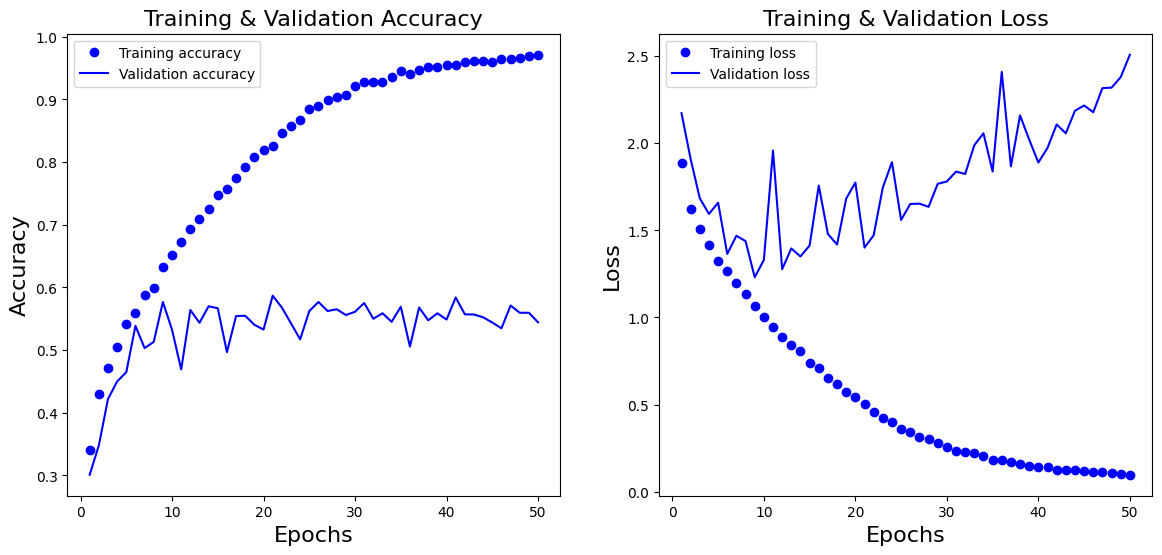

In [27]:
history_dict = hist.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the model accuracy vs Epochs
ax[0].plot(epochs, accuracy, 'bo', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()

# Plot the loss vs Epochs
ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()